INF6804<br>
Polytechnique Montréal<br>
TP3: Détection et suivi de multiples objets d'intérêt<br>

Auteurs:<br>
Marc-Olivier Bélanger - 1840713<br>
Pierre-Luc Chartier - 1805679

### Déclarations globales

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import scipy.optimize as sci
import torchvision.models as models
import torchvision.transforms as transforms
import urllib.request as request

In [3]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
    COCO_NAMES.append(label_name.strip().decode('UTF-8'))

IOU_THRESHOLD = 0.5
SCORE_THRESHOLD = 0.95

source_path = "/Users/mabelal/Downloads/TP3_data/frames"

model = models.detection.maskrcnn_resnet50_fpn(pretrained=True).eval()

In [4]:
# taken from https://answers.opencv.org/question/90455/how-to-perform-intersection-or-union-operations-on-a-rect-in-python/
def intersection_area(a, b):
    x_min = max(a[0], b[0])
    y_min = max(a[1], b[1])
    x_max = min(a[2], b[2])
    y_max = min(a[3], b[3])
    
    width = x_max - x_min
    height = y_max - y_min
    
    if width < 0 or height < 0:
        return 0
    
    return width*height


def union_area(a, b):
    w_a = a[2] - a[0]
    h_a = a[3] - a[1]
    
    w_b = b[2] - b[0]
    h_b = b[3] - b[1]
    
    area_a = w_a * h_a
    area_b = w_b * h_b
    
    return area_a + area_b - intersection_area(a, b)


def intersection_over_union(a, b):
    return intersection_area(a, b) / union_area(a, b)

### Détection des objets (Mask R-CNN)

In [12]:
def detect_objects(img):
    preprocess = transforms.Compose([transforms.ToTensor()])
    tensors = [preprocess(img)]
    
    predictions = model(tensors)
    boxes = []
    
    for p in predictions:
        for j, score in enumerate(p['scores']):
            if score >= SCORE_THRESHOLD:
                label = p['labels'][j]
                is_cup_or_person = (COCO_NAMES[label] == "cup") #or (COCO_NAMES[label] == "person")

                if is_cup_or_person:
                    boxes.append(p['boxes'][j].detach().numpy())
    return boxes

### Description des objets (Histogramme de couleurs)

In [6]:
def calc_color_hist(img, bbox):
    roi = (bbox[0], bbox[1], bbox[2], bbox[3])
    mask = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    cv2.rectangle(mask,(roi[0],roi[1]),(roi[2],roi[3]),255,-1,8,0);
    return cv2.calcHist([img],[0],mask,[64],[0,256])


def compare_color_hist(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

### Association des données (Mean-Shift et algorithme hongrois)

In [39]:
def calc_cost_matrix(tracked_objects, current_img, current_bboxes):
    cost_matrix = np.zeros((len(tracked_objects), len(current_bboxes)))
    for i in range(0,len(tracked_objects)):
        for j in range(0,len(current_bboxes)):
            hist_current = calc_color_hist(current_img, current_bboxes[j])
            cost_matrix[i,j] = compare_color_hist(tracked_objects[i].histogram, hist_current)
    return cost_matrix


def mean_shift(tracked_obj, current_img):           
    retro = cv2.calcBackProject([current_img], [0], tracked_obj.histogram, [0,64], 1)

    end_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
    
    to_box = tracked_obj.box()    
    iterations, box = cv2.meanShift(retro, (to_box[0], to_box[1], to_box[2]-to_box[0], to_box[3]-to_box[1]), end_crit)
    x_min, y_min, width, height = box
    
    return x_min, y_min, x_min+width, y_min+height

        
def associate_data(tracked_objects, current_img, current_bboxes):    
    cost_matrix = calc_cost_matrix(tracked_objects, current_img, current_bboxes)
    row_ind, col_ind = sci.linear_sum_assignment(cost_matrix)
    
    for i in range(0, len(row_ind)):
        # check if association from hungarian algorithm makes sense based on IOU
        iou_score = intersection_over_union(tracked_objects[row_ind[i]].box(), current_bboxes[col_ind[i]])
        if iou_score > IOU_THRESHOLD:
            # model detected object, update it with its predicted bbox and update its description
            tracked_objects[row_ind[i]].was_detected = True
            x_min, y_min, x_max, y_max = current_bboxes[col_ind[i]]
            tracked_objects[row_ind[i]].update(x_min, y_min, x_max, y_max)
            tracked_objects[row_ind[i]].histogram = calc_color_hist(current_img, tracked_objects[row_ind[i]].box())
    
    # apply mean-shift to tracked objects that were not detected by the model
    # update to predicted box if IOU > threshold
    for ob in tracked_objects.values():
        if not ob.was_detected:
            x_min, y_min, x_max, y_max = mean_shift(ob, current_img)
            
            #iou_score = intersection_over_union(ob.box(), (x_min, y_min, x_max, y_max))
            #if iou_score > IOU_THRESHOLD:
            ob.update(x_min, y_min, x_max, y_max)
        else:
            # reset for next frame
            ob.was_detected = False          
            
    return row_ind, col_ind

### Algorithme principal

In [8]:
class TrackedObject:
    def __init__(self, object_id, x_min, y_min, x_max, y_max):
        self.object_id = object_id
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.was_detected = False
        self.histogram = None
    
    
    def update(self, x_min, y_min, x_max, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
            
    
    def box(self):
        return self.x_min, self.y_min, self.x_max, self.y_max
    
    
    def __str__(self):
        ws = " "
        return ws.join([str(self.object_id+1), str(round(self.x_min)),
                        str(round(self.x_max)), str(round(self.y_min)), str(round(self.y_max))])

In [9]:
def algo(path_to_frames, tracked_objects, result_file):
    # some magic to get the frames in the right order
    frames = [name for name in os.listdir(path_to_frames) if os.path.isfile(os.path.join(path_to_frames, name))]
    frames = sorted(frames)
    frames = sorted(frames, key = lambda s : len(s))
    
    # initial frame
    prev_img = cv2.imread(os.path.join(path_to_frames, frames[0]), cv2.IMREAD_GRAYSCALE)
    for ob in tracked_objects.values():
        ob.histogram = calc_color_hist(prev_img, ob.box())
    
    f = open(result_file, "w+")
    for i in range(0, len(tracked_objects)):
        f.write("1 " + str(tracked_objects[i]) + "\n")
    
    # main loop
    for i in range(1, len(frames)):
        img = cv2.imread(os.path.join(path_to_frames, frames[i]), cv2.IMREAD_GRAYSCALE)
        boxes = detect_objects(img)
        associate_data(tracked_objects, img, boxes)
        
        for j in range(0, len(tracked_objects)):
            f.write(str(i+1) + " " + str(tracked_objects[j]) + "\n")
        
        prev_img = img
        
        if (i % 5) == 0:
            print("Progress: " + frames[i])
    
    f.close()

In [10]:
def algo_mot():
    return None

### Test de l'association des données

1 588 799 363 577
2 1062 1441 555 981


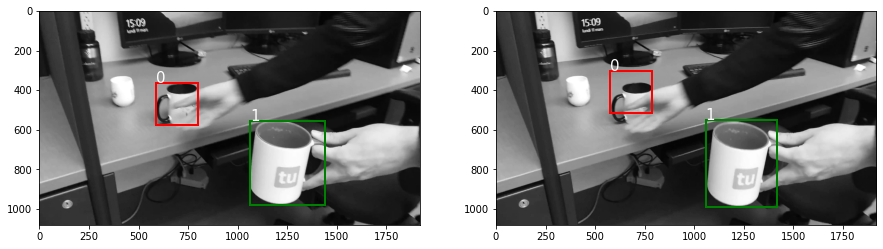

1 574 785 302 516
2 1058 1420 549 991


In [13]:
### Test association des données ###

img = cv2.imread(os.path.join(source_path, "frame124.jpg"), cv2.IMREAD_GRAYSCALE)
cup_1 = TrackedObject(0, 588, 363, 799, 577)
cup_2 = TrackedObject(1, 1062, 555, 1441, 981)

# modelisation des objets a partir de la premiere image
first_img = cv2.imread(os.path.join(source_path, "frame1.jpg"), cv2.IMREAD_GRAYSCALE)
cup_1.histogram = calc_color_hist(first_img, cup_1.box())
cup_2.histogram = calc_color_hist(first_img, cup_2.box())

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}

img2 = cv2.imread(os.path.join(source_path, "frame125.jpg"), cv2.IMREAD_GRAYSCALE)
b2 = detect_objects(img2)

fig, axarr = plt.subplots(1, 2, figsize=(15,15))
bboxcolor = 'rgbcmy'

axarr[0].imshow(img, cmap = plt.cm.gray)
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[0].add_patch(rect)
    axarr[0].text(b[0], b[1], i, color='white', fontsize=15)

for to in tracked_objects.values():
    print(to)

row_ind, col_ind = associate_data(tracked_objects, img2, b2)
#print(row_ind)
#print(col_ind)

axarr[1].imshow(img2, cmap = plt.cm.gray)
#for i, b in enumerate(b2):
for i in range(0, len(tracked_objects)):
    b = tracked_objects[i].box()
    rect = patches.Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2, edgecolor = bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    rect = patches.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor=bboxcolor[i], facecolor='none')
    axarr[1].add_patch(rect)
    axarr[1].text(b[0], b[1], i, color='white', fontsize=15)
    
plt.show()

for to in tracked_objects.values():
    print(to)

############

### MOT17-11: Forward moving camera in a busy shopping mall

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

# will need to create tracked_objects or smtg
# call algo, print in results file, then use the file to compute MOTA

### MOT17-05: Street scene from a moving platform

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

### MOT17-13 : Filmed from a bus on a busy intersection

In [ ]:
# calcul du MOTA en utilisant IoU > 50%

### Résultats sur les trames fournies

In [ ]:
# init.txt
cup_1 = TrackedObject(0, 830, 474, 1112, 755)
cup_2 = TrackedObject(1, 1194, 433, 1479, 700)

tracked_objects = {
    cup_1.object_id : cup_1,
    cup_2.object_id : cup_2
}

algo("/Users/mabelal/Downloads/TP3_data/frames", tracked_objects, "result_cups.txt")

Progress: frame6.jpg


### Validation des résultats

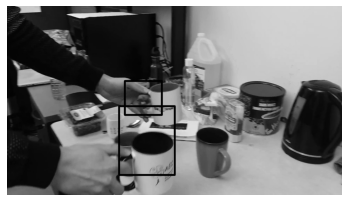

frame451.jpg
451 1 675 887 428 622

451 2 642 961 572 965



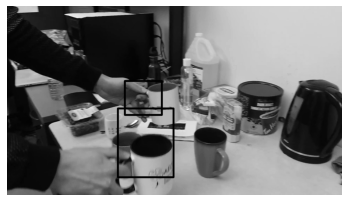

frame452.jpg
452 1 675 887 428 622

452 2 635 954 585 978



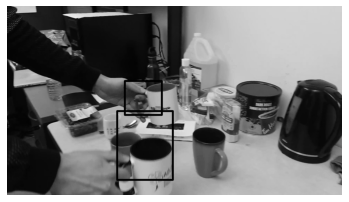

frame453.jpg
453 1 675 887 428 622

453 2 631 950 600 993



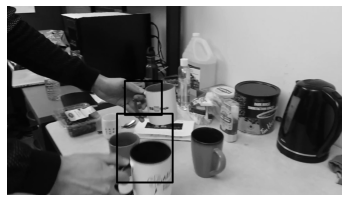

frame454.jpg
454 1 675 887 428 622

454 2 630 949 615 1008



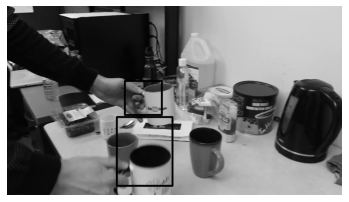

frame455.jpg
455 1 675 887 428 622

455 2 629 948 634 1027



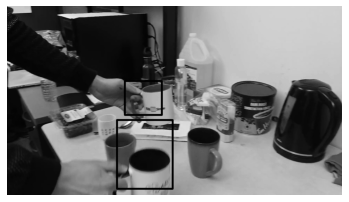

frame456.jpg
456 1 675 887 428 622

456 2 630 949 651 1044



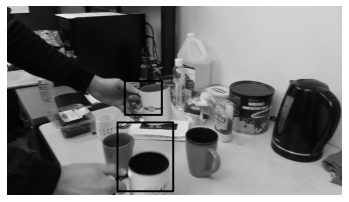

frame457.jpg
457 1 675 887 428 622

457 2 633 952 665 1058



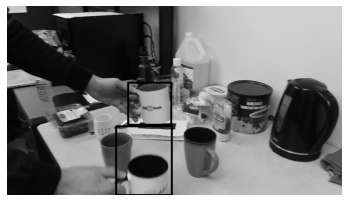

frame458.jpg
458 1 694 941 438 678

458 2 625 944 687 1080



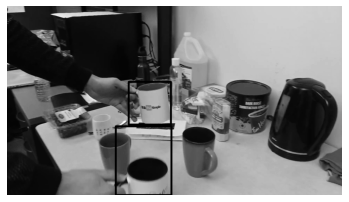

frame459.jpg
459 1 697 939 433 677

459 2 623 942 687 1080



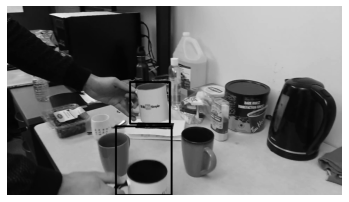

frame460.jpg
460 1 705 933 434 672

460 2 624 943 687 1080



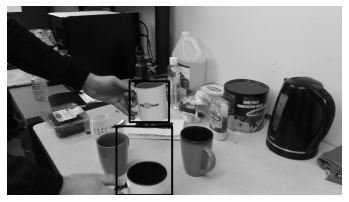

frame461.jpg
461 1 702 928 430 663

461 2 627 946 687 1080



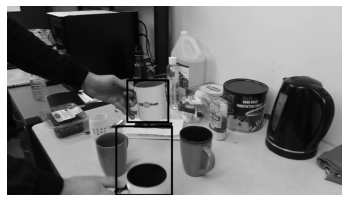

frame462.jpg
462 1 689 924 424 663

462 2 626 945 687 1080



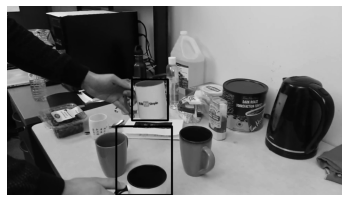

frame463.jpg
463 1 716 922 419 653

463 2 626 945 687 1080



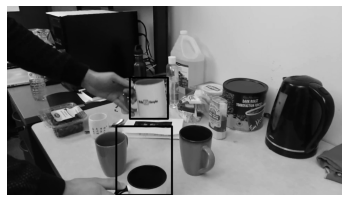

frame464.jpg
464 1 704 922 409 644

464 2 626 945 687 1080



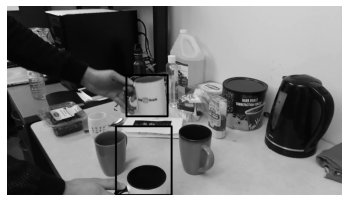

frame465.jpg
465 1 684 920 394 630

465 2 624 943 687 1080



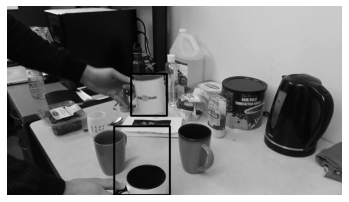

frame466.jpg
466 1 711 916 387 627

466 2 614 933 687 1080



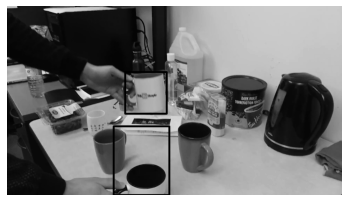

frame467.jpg
467 1 677 915 377 615

467 2 611 930 687 1080



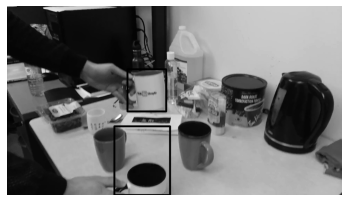

frame468.jpg
468 1 690 912 361 602

468 2 615 934 687 1080



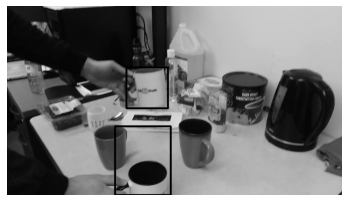

frame469.jpg
469 1 684 922 350 584

469 2 619 938 687 1080



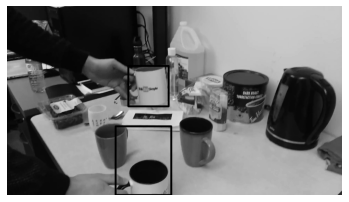

frame470.jpg
470 1 695 926 342 573

470 2 622 941 687 1080



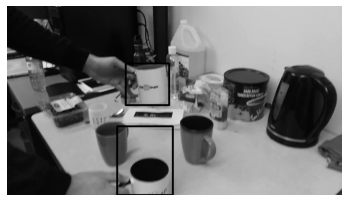

frame471.jpg
471 1 680 929 328 566

471 2 631 950 687 1080



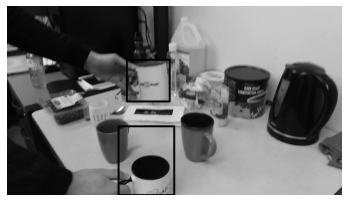

frame472.jpg
472 1 687 932 307 545

472 2 639 958 687 1080



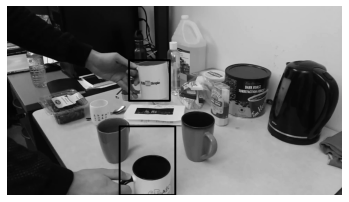

frame473.jpg
473 1 699 933 309 541

473 2 645 964 687 1080



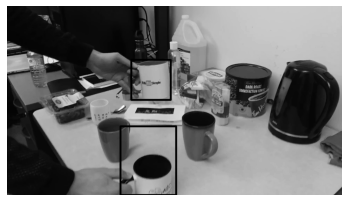

frame474.jpg
474 1 712 938 307 536

474 2 650 969 687 1080



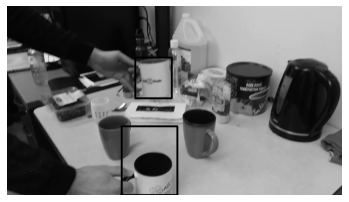

frame475.jpg
475 1 735 944 294 527

475 2 657 976 687 1080



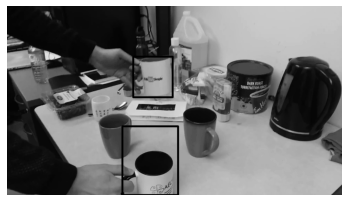

frame476.jpg
476 1 723 949 289 521

476 2 661 980 687 1080



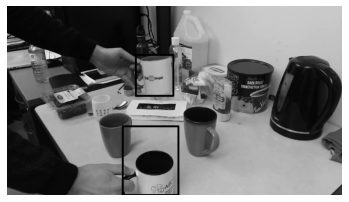

frame477.jpg
477 1 738 953 279 513

477 2 663 982 687 1080



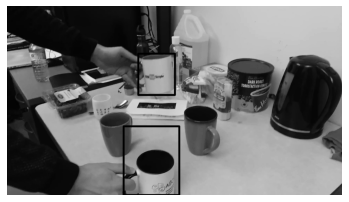

frame478.jpg
478 1 752 962 272 508

478 2 668 987 687 1080



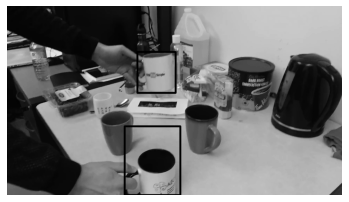

frame479.jpg
479 1 747 966 262 496

479 2 674 993 687 1080



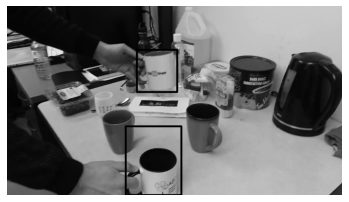

frame480.jpg
480 1 744 975 250 491

480 2 680 999 687 1080



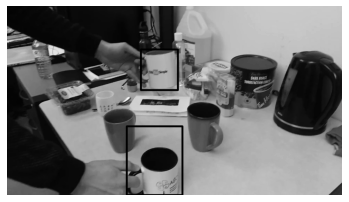

frame481.jpg
481 1 767 979 248 480

481 2 686 1005 687 1080



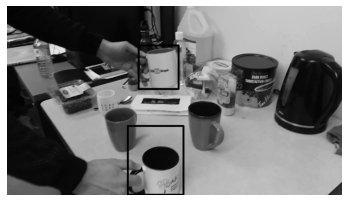

frame482.jpg
482 1 754 983 225 474

482 2 692 1011 685 1078



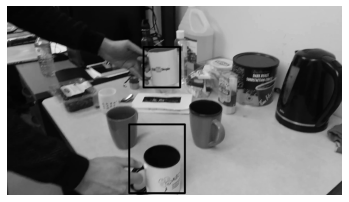

frame483.jpg
483 1 782 992 234 465

483 2 700 1019 676 1069



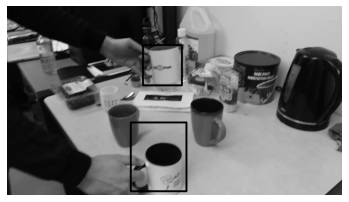

frame484.jpg
484 1 779 1002 223 453

484 2 709 1028 665 1058



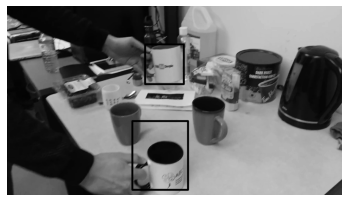

frame485.jpg
485 1 791 1013 219 446

485 2 718 1037 657 1050



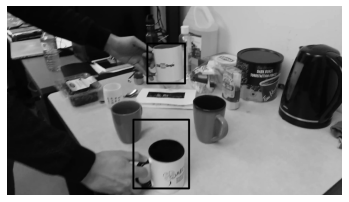

frame486.jpg
486 1 804 1020 214 442

486 2 724 1043 649 1042



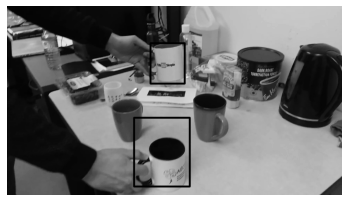

frame487.jpg
487 1 822 1018 212 443

487 2 728 1047 638 1031



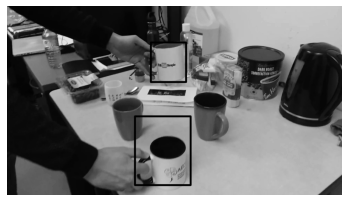

frame488.jpg
488 1 824 1026 208 434

488 2 733 1052 630 1023



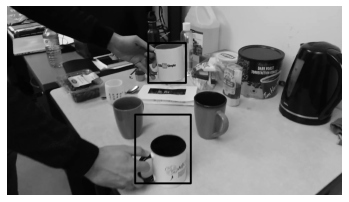

frame489.jpg
489 1 809 1025 211 439

489 2 734 1053 620 1013



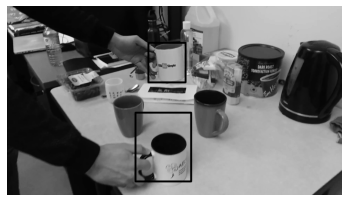

frame490.jpg
490 1 810 1023 210 436

490 2 736 1055 609 1002



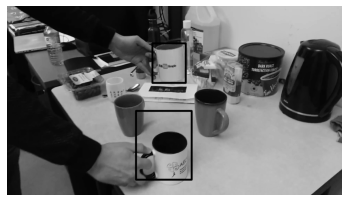

frame491.jpg
491 1 833 1024 213 439

491 2 739 1058 599 992



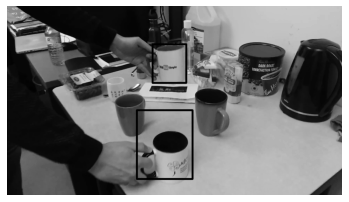

frame492.jpg
492 1 834 1027 218 439

492 2 744 1063 595 988



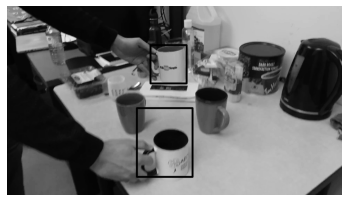

frame493.jpg
493 1 822 1029 223 442

493 2 744 1063 583 976



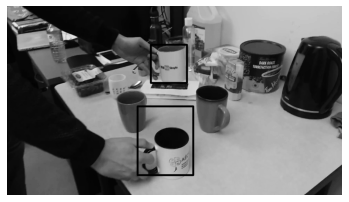

frame494.jpg
494 1 824 1031 221 439

494 2 748 1067 573 966



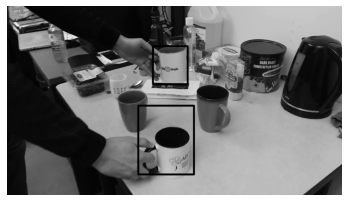

frame495.jpg
495 1 836 1035 229 446

495 2 752 1071 569 962



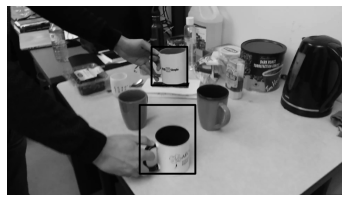

frame496.jpg
496 1 828 1033 233 453

496 2 760 1079 565 958



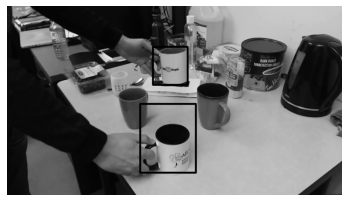

frame497.jpg
497 1 836 1035 233 450

497 2 763 1082 559 952



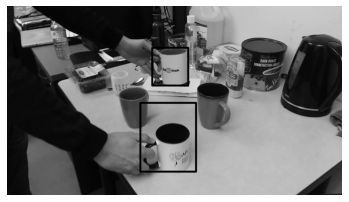

frame498.jpg
498 1 832 1038 238 454

498 2 764 1083 553 946



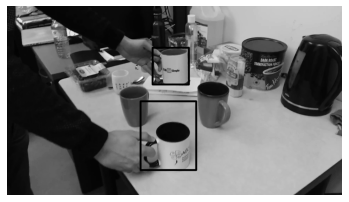

frame499.jpg
499 1 834 1042 238 448

499 2 765 1084 544 937



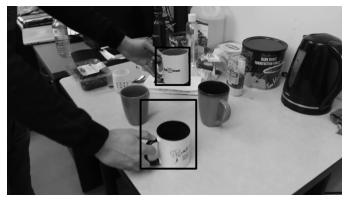

frame500.jpg
500 1 852 1046 237 451

500 2 765 1084 536 929



In [38]:
### Validation des résultats

f = open("result_cups.txt", "r")
lines = f.readlines()
f.close()

frames = [name for name in os.listdir(source_path) if os.path.isfile(os.path.join(source_path, name))]
frames = sorted(frames)
frames = sorted(frames, key = lambda s : len(s))

i = 451
for j in range (0, 50):
    img = cv2.imread(os.path.join(source_path, frames[i-1+j]), cv2.IMREAD_GRAYSCALE)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    x_min, x_max, y_min, y_max = lines[(2*(i-1+j))+1].split(" ")[-4:]
    img = cv2.rectangle(img, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0,0,0), 10)
    
    plt.imshow(img, cmap=plt.cm.gray)
    plt.axis("off")
    plt.show()
    
    print(frames[i-1+j])
    print(lines[(2*(i-1+j))])
    print(lines[(2*(i-1+j))+1])
